# 📈 Stock Price Prediction Using PySpark and Machine Learning

## **Introduction**
This notebook focuses on predicting stock prices for major financial assets, including AAPL, META, and the S&P 500, using machine learning models. The goal is to analyze historical stock data and evaluate the effectiveness of different predictive models.

We begin by performing Exploratory Data Analysis (EDA) to understand the structure of the data, identify trends, and uncover any patterns that might influence stock prices. EDA helps us prepare the data for modeling by addressing issues like missing values, outliers, and feature selection.


## **Data and Methodology**
- **Dataset:** Historical stock prices collected from [Yahoo Finance].
- **Features:** Includes stock price movements, technical indicators (e.g., Moving Averages, RSI), and market trends.
- **Models Used:**
  - Linear Regression
  - Random Forest Regressor
  - Gradient Boosting Trees (GBT)
- **Evaluation Metrics:**
  - Root Mean Squared Error (RMSE)
  - Mean Absolute Error (MAE)
  - R-squared (R²)

Through this analysis, we aim to assess which model provides the most accurate stock price predictions and explore areas for further improvement.


## Phase 1: Data Collection & Preprocessing

In [ ]:
!pip install pyspark yfinance matplotlib seaborn scikit-learn tensorflow

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, max, min, stddev, count
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [ ]:
spark = SparkSession.builder.appName("StockPricePrediction").config("spark.driver.memory", "4g").getOrCreate()

In [ ]:
def fetch_stock_data(ticker, start_date="2015-01-01", end_date="2024-01-01"):
    data = yf.download(ticker, start=start_date, end=end_date)
    df = data.reset_index()

    # Flatten column names if they are multi-indexed
    df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

    return df

# Fetch data for Apple (AAPL), Meta (META), and S&P 500 (^GSPC)
aapl_df = fetch_stock_data("AAPL")
meta_df = fetch_stock_data("META")
sp500_df = fetch_stock_data("^GSPC")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Preprocessing

Preparing the stock price data (for AAPL, META, and S&P 500) for analysis by converting it into PySpark DataFrames, formatting the date column correctly, and handling missing values. This will ensure the data is clean and ready for further analysis and machine learning modeling.

In [ ]:
# Convert data into PySpark DataFrames
aapl_spark_df = spark.createDataFrame(aapl_df)
meta_spark_df = spark.createDataFrame(meta_df)
sp500_spark_df = spark.createDataFrame(sp500_df)

# Format Date Column Properly
def preprocess_data(df):
    df = df.withColumnRenamed("Date", "date")  # Ensure correct column naming
    df = df.withColumn("date", col("date").cast("timestamp"))
    return df


aapl_spark_df = preprocess_data(aapl_spark_df)
meta_spark_df = preprocess_data(meta_spark_df)
sp500_spark_df = preprocess_data(sp500_spark_df)

# Handle Missing Values
def handle_missing_values(df):
    return df.dropna()

aapl_spark_df = handle_missing_values(aapl_spark_df)
meta_spark_df = handle_missing_values(meta_spark_df)
sp500_spark_df = handle_missing_values(sp500_spark_df)

###Feature Engineering

Performing feature engineering on the stock price data for AAPL, META, and the S&P 500 by calculating key technical indicators to enhance predictive modeling.

In [ ]:
from pyspark.sql.functions import col, lag, avg, stddev, when
from pyspark.sql.window import Window

def add_features(df):
    window_spec_50 = Window.orderBy("date").rowsBetween(-49, 0)  # 50-day window
    window_spec_200 = Window.orderBy("date").rowsBetween(-199, 0)  # 200-day window

    # Moving Averages
    df = df.withColumn("50_MA", avg(col("Close")).over(window_spec_50))
    df = df.withColumn("200_MA", avg(col("Close")).over(window_spec_200))

    # Volatility - Rolling Standard Deviation over 10 days
    df = df.withColumn("Volatility", stddev(col("Close")).over(window_spec_50))

    # Momentum - Difference between current and previous closing price
    df = df.withColumn("Momentum", col("Close") - lag(col("Close"), 1).over(Window.orderBy("date")))

    # Compute Relative Strength Index (RSI)
    df = df.withColumn("Gain", when(col("Momentum") > 0, col("Momentum")).otherwise(0))
    df = df.withColumn("Loss", when(col("Momentum") < 0, -col("Momentum")).otherwise(0))
    df = df.withColumn("Avg_Gain", avg(col("Gain")).over(window_spec_50))
    df = df.withColumn("Avg_Loss", avg(col("Loss")).over(window_spec_50))
    df = df.withColumn("RSI", 100 - (100 / (1 + (col("Avg_Gain") / col("Avg_Loss")))))

    # Drop intermediate RSI calculations and handle missing values
    df = df.drop("Gain", "Loss", "Avg_Gain", "Avg_Loss")
    df = df.fillna(0)  # Fill missing values

    return df

# Apply feature engineering to each stock dataset
aapl_spark_df = add_features(aapl_spark_df)
meta_spark_df = add_features(meta_spark_df)
sp500_spark_df = add_features(sp500_spark_df)

In [ ]:
# Display first 10 rows of the DataFrames
print("Apple (AAPL) Data Sample:")
aapl_spark_df.show(10)

print("Meta (META) Data Sample:")
meta_spark_df.show(10)

print("S&P 500 (^GSPC) Data Sample:")
sp500_spark_df.show(10)

Apple (AAPL) Data Sample:
+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------------+-------------------+--------------------+-------------------+
|               date|             Close|              High|               Low|              Open|   Volume|             50_MA|            200_MA|         Volatility|            Momentum|                RSI|
+-------------------+------------------+------------------+------------------+------------------+---------+------------------+------------------+-------------------+--------------------+-------------------+
|2015-01-02 00:00:00|24.320432662963867| 24.78980179223696| 23.87998139150813|24.778678625376525|212818400|24.320432662963867|24.320432662963867|                0.0|                 0.0|                0.0|
|2015-01-05 00:00:00|23.635290145874023|24.169169980365208| 23.44843313723857|24.089087920333668|257142000|23.977861404418945|23.977861404418945|0

In [ ]:
print("AAPL Data Columns:", aapl_spark_df.columns)
print("META Data Columns:", meta_spark_df.columns)
print("S&P 500 Data Columns:", sp500_spark_df.columns)


AAPL Data Columns: ['date', 'Close', 'High', 'Low', 'Open', 'Volume', '50_MA', '200_MA', 'Volatility', 'Momentum', 'RSI']
META Data Columns: ['date', 'Close', 'High', 'Low', 'Open', 'Volume', '50_MA', '200_MA', 'Volatility', 'Momentum', 'RSI']
S&P 500 Data Columns: ['date', 'Close', 'High', 'Low', 'Open', 'Volume', '50_MA', '200_MA', 'Volatility', 'Momentum', 'RSI']


## Phase 2 : Exploratory Data Analysis(EDA)

### 1️⃣ Price Trend Analysis

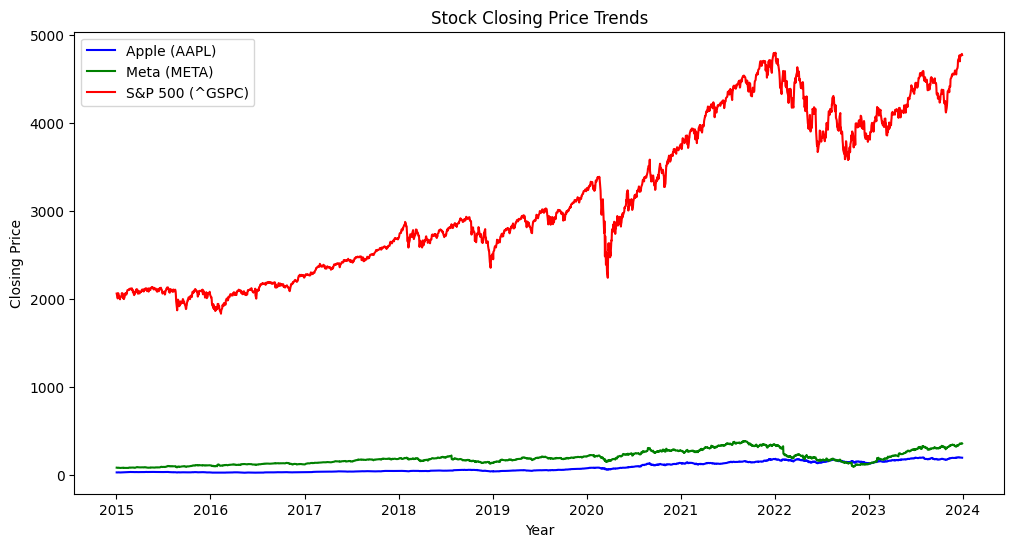

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(aapl_df["Date"], aapl_df["Close"], label="Apple (AAPL)", color="blue")
plt.plot(meta_df["Date"], meta_df["Close"], label="Meta (META)", color="green")
plt.plot(sp500_df["Date"], sp500_df["Close"], label="S&P 500 (^GSPC)", color="red")
plt.xlabel("Year")
plt.ylabel("Closing Price")
plt.title("Stock Closing Price Trends")
plt.legend()
plt.show()

### 2️⃣ Moving Averages & Bollinger Bands


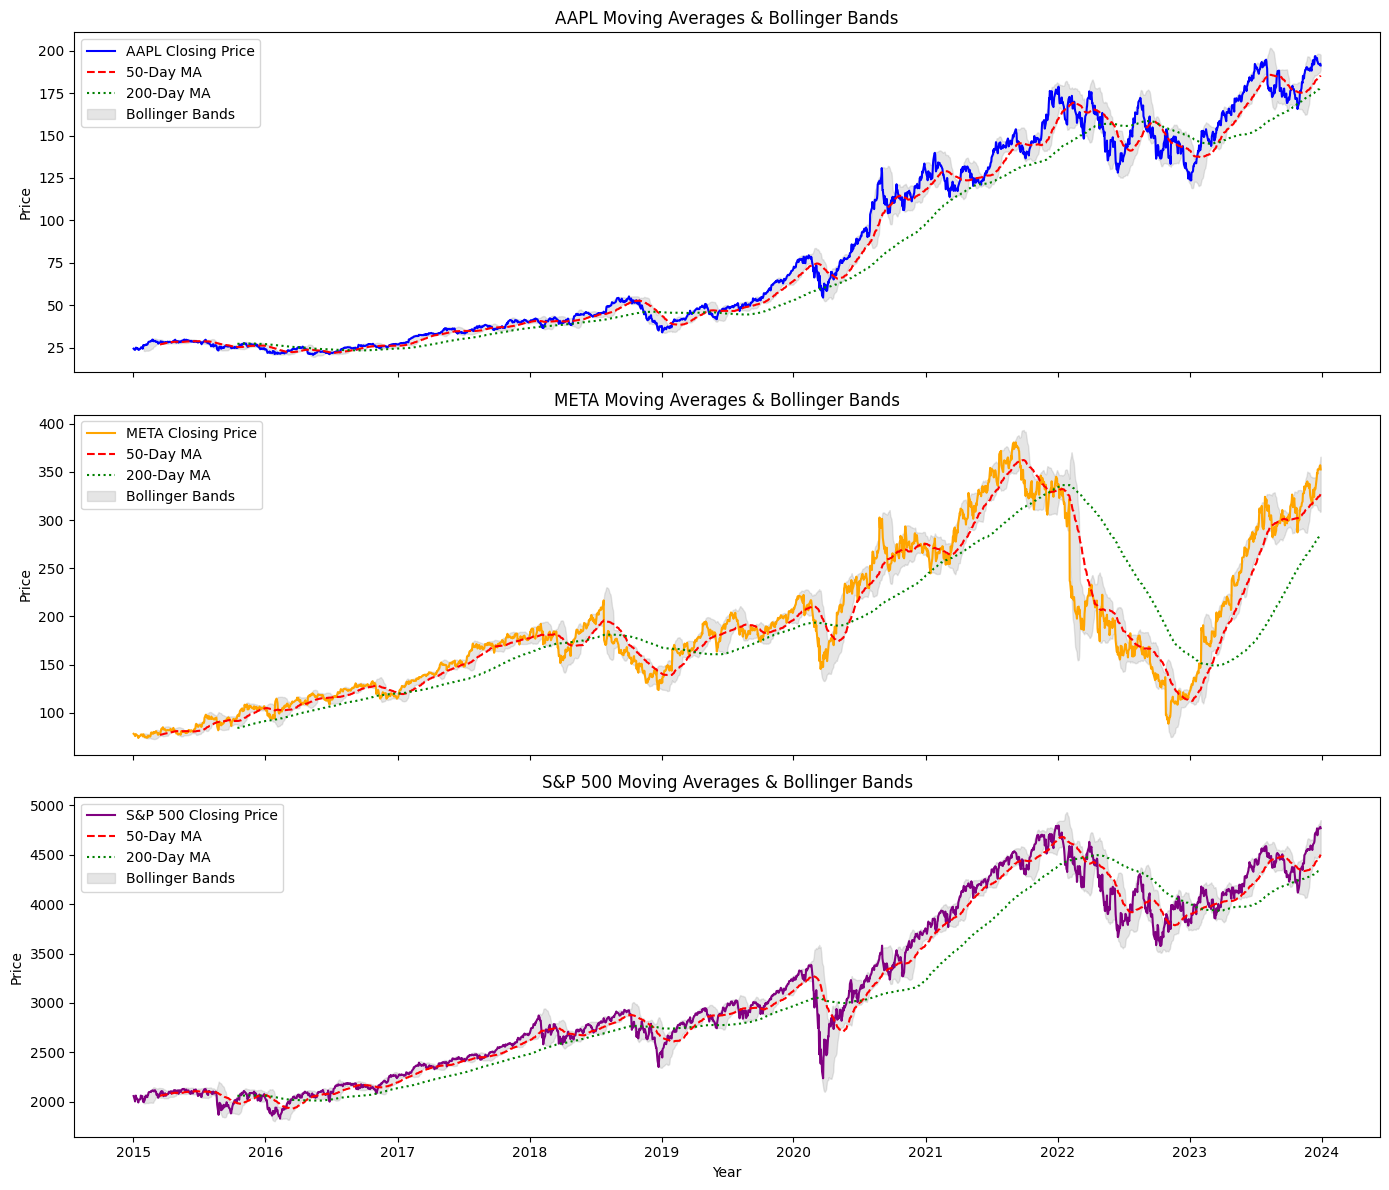

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)  # 3 subplots in one column, sharing x-axis
stock_data = zip([aapl_df, meta_df, sp500_df], ["AAPL", "META", "S&P 500"], ["blue", "orange", "purple"], axes)

for df, label, color, ax in stock_data:
    df["50_MA"] = df["Close"].rolling(window=50).mean()
    df["200_MA"] = df["Close"].rolling(window=200).mean()
    df["Upper_Band"] = df["Close"].rolling(window=20).mean() + (df["Close"].rolling(window=20).std() * 2)
    df["Lower_Band"] = df["Close"].rolling(window=20).mean() - (df["Close"].rolling(window=20).std() * 2)

    ax.plot(df["Date"], df["Close"], label=f"{label} Closing Price", color=color)
    ax.plot(df["Date"], df["50_MA"], linestyle="dashed", color="red", label="50-Day MA")
    ax.plot(df["Date"], df["200_MA"], linestyle="dotted", color="green", label="200-Day MA")
    ax.fill_between(df["Date"], df["Upper_Band"], df["Lower_Band"], color="gray", alpha=0.2, label="Bollinger Bands")

    ax.set_ylabel("Price")
    ax.set_title(f"{label} Moving Averages & Bollinger Bands")
    ax.legend()

axes[-1].set_xlabel("Year")  # Only the last subplot gets the x-axis label
plt.tight_layout()
plt.show()



### 3️⃣ Sharpe Ratio (Risk-Return Tradeoff)





In [ ]:
# Sharpe Ratio Calculation
def calculate_sharpe_ratio(df, risk_free_rate=0.02):
    df["Daily Return"] = df["Close"].pct_change()
    avg_return = df["Daily Return"].mean()
    std_dev = df["Daily Return"].std()

    sharpe_ratio = (avg_return - risk_free_rate / 252) / std_dev  # Adjusting for daily returns
    return sharpe_ratio

# Compute Sharpe Ratios
sharpe_aapl = calculate_sharpe_ratio(aapl_df)
sharpe_meta = calculate_sharpe_ratio(meta_df)
sharpe_sp500 = calculate_sharpe_ratio(sp500_df)

# Print Results
print(f"Sharpe Ratio for AAPL: {sharpe_aapl:.4f}")
print(f"Sharpe Ratio for META: {sharpe_meta:.4f}")
print(f"Sharpe Ratio for S&P 500: {sharpe_sp500:.4f}")


Sharpe Ratio for AAPL: 0.0547
Sharpe Ratio for META: 0.0368
Sharpe Ratio for S&P 500: 0.0311


AAPL (0.0547) has the highest Sharpe Ratio → This means it has the best risk-adjusted return among the three, though still not strong (ideally >1).<br>
META (0.0368) and S&P 500 (0.0311) have lower Sharpe Ratios → They offer less reward per unit of risk, making them less attractive from a risk-return perspective.<br>
All three Sharpe Ratios are far below 1, suggesting that their risk-adjusted returns are not highly favorable.<br>
S&P 500 has the lowest Sharpe Ratio → This suggests that it has lower volatility but also lower excess returns.

### 4️⃣ Volatility & Returns Analysis

In [ ]:
from pyspark.sql.functions import col, lag, stddev, mean, expr
from pyspark.sql.window import Window

# Function to calculate daily returns and rolling volatility
def calculate_returns_and_volatility(df, ticker):
    window_spec = Window().orderBy("date")

    df = df.withColumn("daily_return", (col("Close") - lag("Close").over(window_spec)) / lag("Close").over(window_spec))
    df = df.withColumn("rolling_volatility", stddev("daily_return").over(Window().orderBy("date").rowsBetween(-29, 0)))

    return df

# Apply function to each stock
aapl_spark_df = calculate_returns_and_volatility(aapl_spark_df, "AAPL")
meta_spark_df = calculate_returns_and_volatility(meta_spark_df, "META")
sp500_spark_df = calculate_returns_and_volatility(sp500_spark_df, "S&P500")

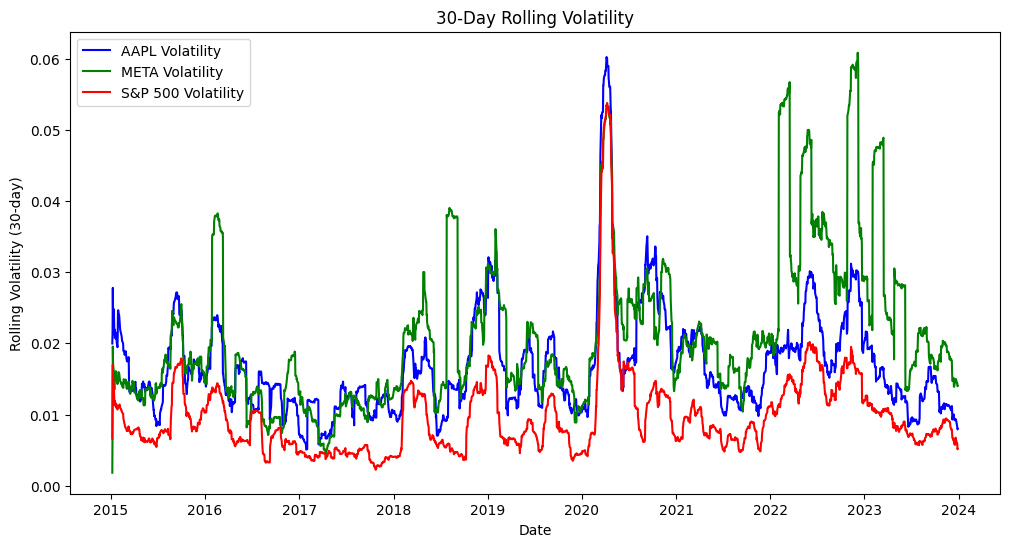

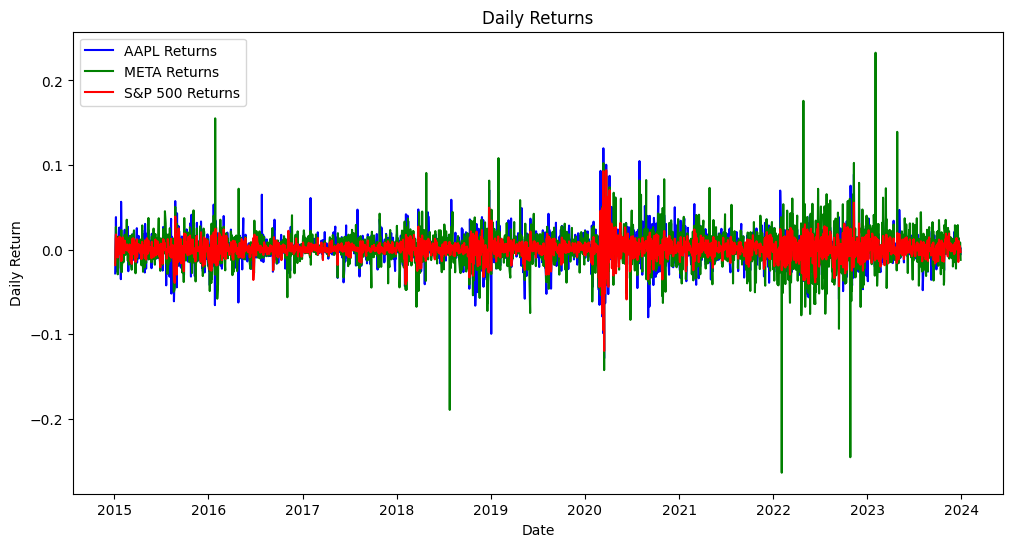

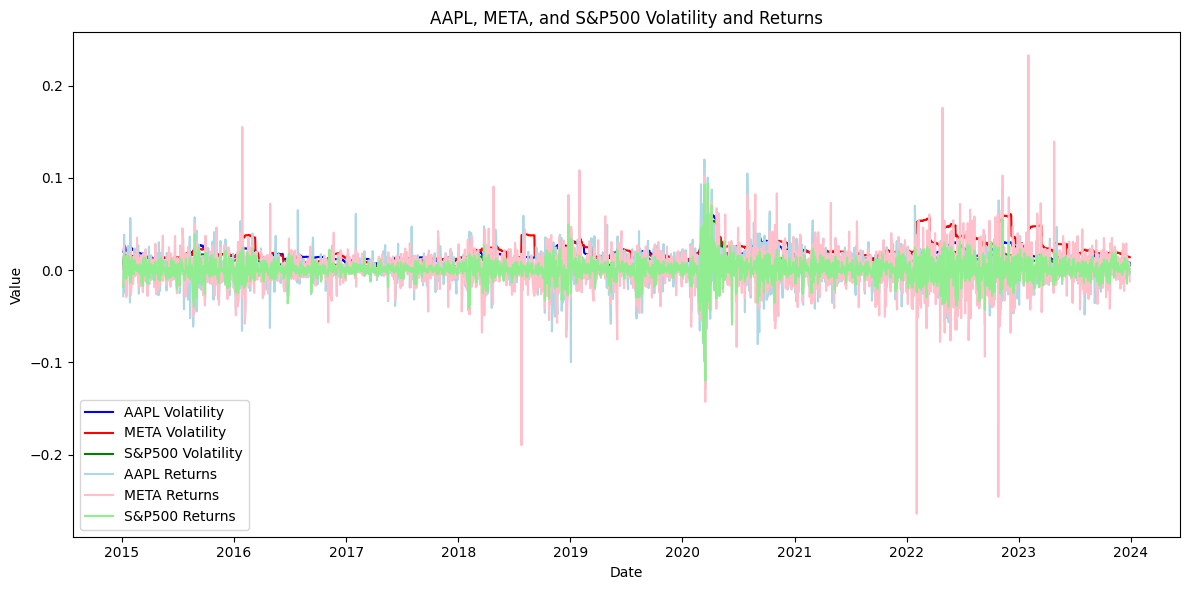

In [ ]:
# Convert Spark DataFrames back to Pandas DataFrames for plotting
aapl_pd_df = aapl_spark_df.toPandas()
meta_pd_df = meta_spark_df.toPandas()
sp500_pd_df = sp500_spark_df.toPandas()

# Plotting Volatility
plt.figure(figsize=(12, 6))
plt.plot(aapl_pd_df["date"], aapl_pd_df["rolling_volatility"], label="AAPL Volatility", color="blue")
plt.plot(meta_pd_df["date"], meta_pd_df["rolling_volatility"], label="META Volatility", color="green")
plt.plot(sp500_pd_df["date"], sp500_pd_df["rolling_volatility"], label="S&P 500 Volatility", color="red")

plt.xlabel("Date")
plt.ylabel("Rolling Volatility (30-day)")
plt.title("30-Day Rolling Volatility")
plt.legend()
plt.show()


# Plotting Daily Returns
plt.figure(figsize=(12, 6))
plt.plot(aapl_pd_df["date"], aapl_pd_df["daily_return"], label="AAPL Returns", color="blue")
plt.plot(meta_pd_df["date"], meta_pd_df["daily_return"], label="META Returns", color="green")
plt.plot(sp500_pd_df["date"], sp500_pd_df["daily_return"], label="S&P 500 Returns", color="red")

plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("Daily Returns")
plt.legend()
plt.show()


# Combined plot of Volatility and Returns for AAPL, META, and S&P500
plt.figure(figsize=(12, 6))
plt.plot(aapl_pd_df["date"], aapl_pd_df["rolling_volatility"], label="AAPL Volatility", color="blue")
plt.plot(meta_pd_df["date"], meta_pd_df["rolling_volatility"], label="META Volatility", color="red")
plt.plot(sp500_pd_df["date"], sp500_pd_df["rolling_volatility"], label="S&P500 Volatility", color="green")

plt.plot(aapl_pd_df["date"], aapl_pd_df["daily_return"], label="AAPL Returns", color="lightblue")
plt.plot(meta_pd_df["date"], meta_pd_df["daily_return"], label="META Returns", color="pink")
plt.plot(sp500_pd_df["date"], sp500_pd_df["daily_return"], label="S&P500 Returns", color="lightgreen")

plt.xlabel("Date")
plt.ylabel("Value")
plt.title("AAPL, META, and S&P500 Volatility and Returns")
plt.legend()
plt.tight_layout()
plt.show()


### 5️⃣ Correlation Analysis

Correlation between AAPL and META: 0.5521338379542008
Correlation between AAPL and S&P 500: 0.7600104616830557
Correlation between META and S&P 500: 0.6132917499314643


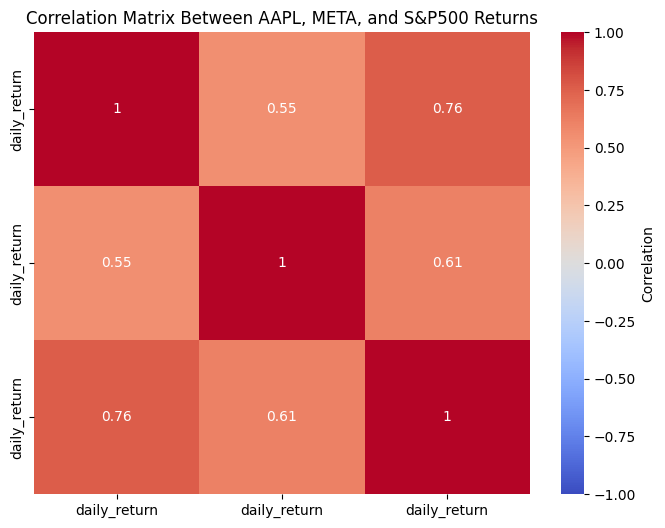

In [ ]:
from pyspark.sql.functions import corr

# Joining the dataframes on the date column
returns_df = aapl_spark_df.select("date", "daily_return").alias("AAPL") \
    .join(meta_spark_df.select("date", "daily_return").alias("META"), "date") \
    .join(sp500_spark_df.select("date", "daily_return").alias("S&P500"), "date")

# Calculate the correlations between the returns
correlation_aapl_meta = returns_df.select(corr("AAPL.daily_return", "META.daily_return")).collect()[0][0]
correlation_aapl_sp500 = returns_df.select(corr("AAPL.daily_return", "S&P500.daily_return")).collect()[0][0]
correlation_meta_sp500 = returns_df.select(corr("META.daily_return", "S&P500.daily_return")).collect()[0][0]

# Display the correlation results
print(f"Correlation between AAPL and META: {correlation_aapl_meta}")
print(f"Correlation between AAPL and S&P 500: {correlation_aapl_sp500}")
print(f"Correlation between META and S&P 500: {correlation_meta_sp500}")

correlation_matrix = returns_df.select("AAPL.daily_return", "META.daily_return", "S&P500.daily_return").toPandas().corr()

# Plotting the correlation matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1, cbar_kws={'label': 'Correlation'})
plt.title("Correlation Matrix Between AAPL, META, and S&P500 Returns")
plt.show()



AAPL and META have a moderate positive correlation of 0.55, indicating they move similarly but not perfectly aligned. AAPL has a strong correlation (0.76) with the S&P 500, reflecting its significant impact on the broader market. META shows a moderate-to-strong correlation of 0.61 with the S&P 500, suggesting it follows market trends but with more divergence than AAPL.

### 6️⃣ Cross-Stock Return Comparison

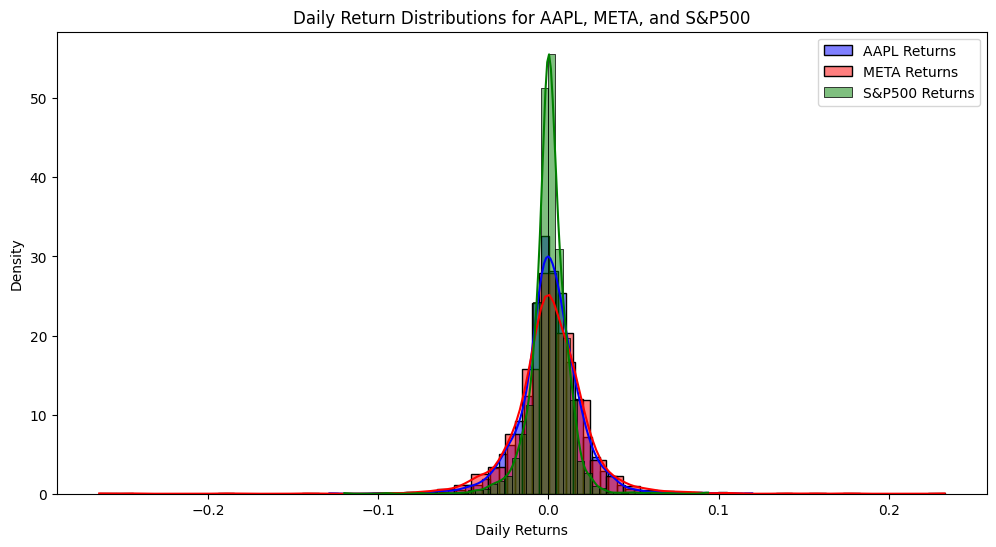

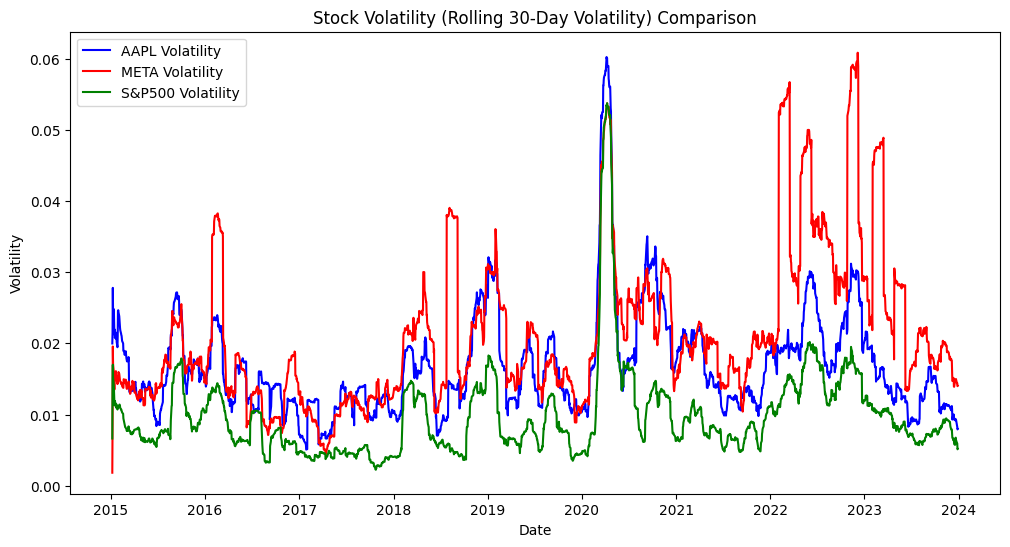

In [ ]:
plt.figure(figsize=(12, 6))

# Plot histograms for daily returns of AAPL, META, and S&P500
sns.histplot(aapl_pd_df["daily_return"], kde=True, label="AAPL Returns", color="blue", stat="density", bins=50, alpha=0.5)
sns.histplot(meta_pd_df["daily_return"], kde=True, label="META Returns", color="red", stat="density", bins=50, alpha=0.5)
sns.histplot(sp500_pd_df["daily_return"], kde=True, label="S&P500 Returns", color="green", stat="density", bins=50, alpha=0.5)

plt.xlabel("Daily Returns")
plt.ylabel("Density")
plt.title("Daily Return Distributions for AAPL, META, and S&P500")
plt.legend()
plt.show()

# Plot Stock Volatility (Rolling Volatility)
plt.figure(figsize=(12, 6))

# Plot Rolling Volatility for AAPL, META, and S&P500
plt.plot(aapl_pd_df["date"], aapl_pd_df["rolling_volatility"], label="AAPL Volatility", color="blue")
plt.plot(meta_pd_df["date"], meta_pd_df["rolling_volatility"], label="META Volatility", color="red")
plt.plot(sp500_pd_df["date"], sp500_pd_df["rolling_volatility"], label="S&P500 Volatility", color="green")

plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title("Stock Volatility (Rolling 30-Day Volatility) Comparison")
plt.legend()
plt.show()

### 7️⃣ Volume Analysis

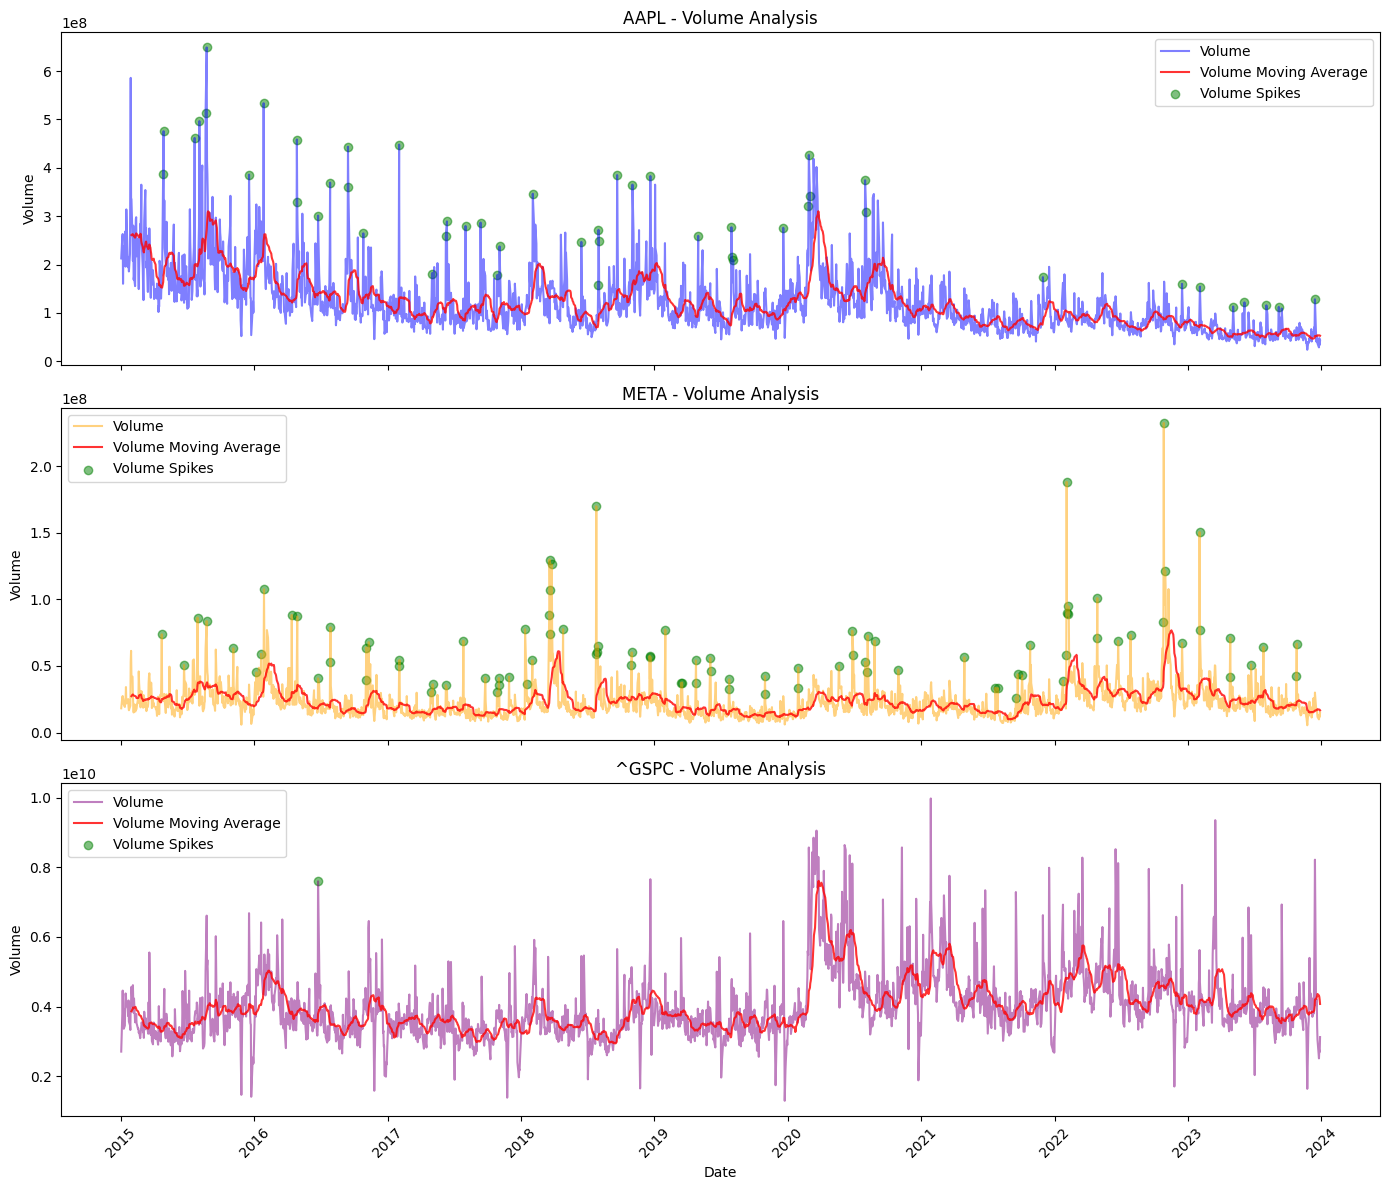

In [ ]:
# Function to analyze volume spikes and trends
def analyze_volume(df, window=20, volume_threshold=2):
    # Calculate the moving average of volume
    df['Volume_MA'] = df['Volume'].rolling(window=window).mean()

    # Identify volume spikes: where volume is higher than the moving average by a threshold
    df['Volume_Spike'] = df['Volume'] > (df['Volume_MA'] * volume_threshold)

    return df

# Analyze volume for each stock
aapl_df = analyze_volume(aapl_df)
meta_df = analyze_volume(meta_df)
sp500_df = analyze_volume(sp500_df)

# Create a single figure with 3 subplots (one for each stock)
fig, axs = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Define a function to plot volume analysis in subplots
def plot_volume_analysis_subplot(ax, df, ticker, color):
    # Plot volume and moving average
    ax.plot(df['Date'], df['Volume'], label='Volume', alpha=0.5, color=color)
    ax.plot(df['Date'], df['Volume_MA'], label='Volume Moving Average', color='red', alpha=0.8)

    # Highlight volume spikes
    ax.scatter(df[df['Volume_Spike']]['Date'], df[df['Volume_Spike']]['Volume'],
               color='green', label='Volume Spikes', alpha=0.5)

    ax.set_title(f'{ticker} - Volume Analysis')
    ax.set_ylabel('Volume')
    ax.legend()

# Plot volume analysis for each stock in separate subplots
plot_volume_analysis_subplot(axs[0], aapl_df, 'AAPL', 'blue')
plot_volume_analysis_subplot(axs[1], meta_df, 'META', 'orange')
plot_volume_analysis_subplot(axs[2], sp500_df, '^GSPC', 'purple')

# Set common x-axis label
axs[-1].set_xlabel("Date")

# Rotate x-axis labels for readability
for ax in axs:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### 8️⃣ Seasonality Analysis

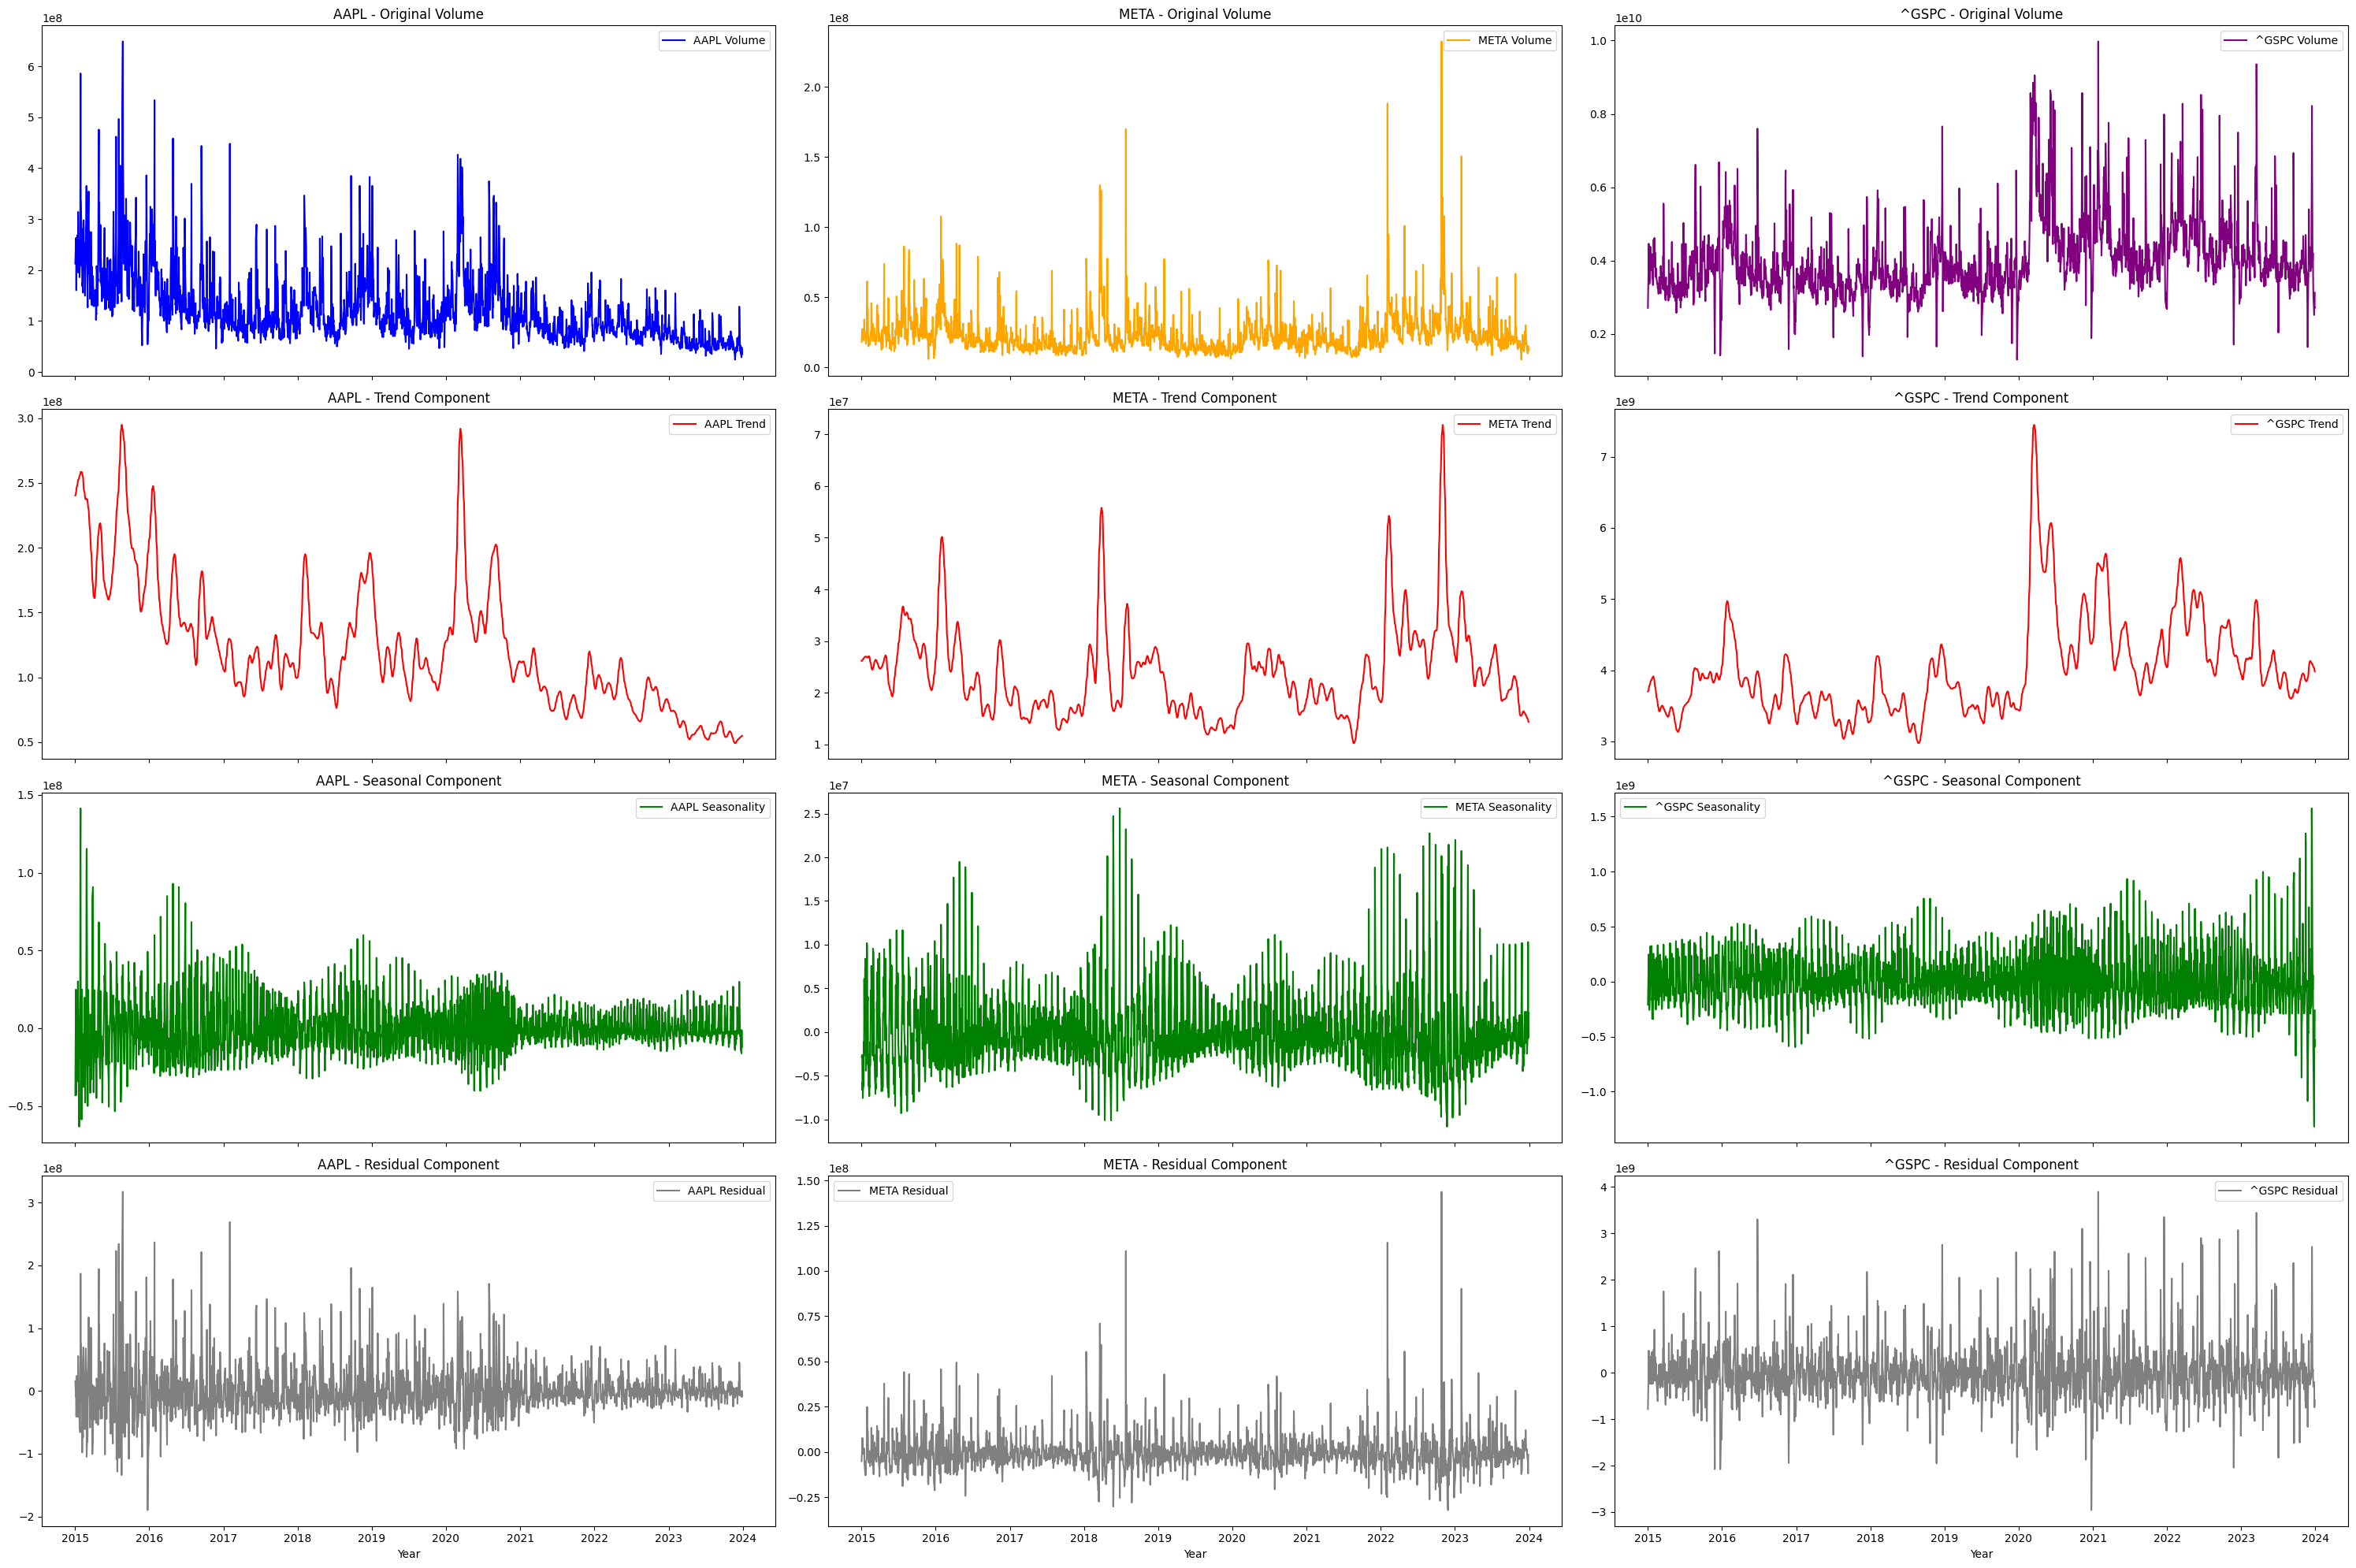

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL

def decompose_volume_subplot(axs, df, ticker, color):
    df = df.copy()
    df.set_index('Date', inplace=True)

    volume = df['Volume']
    decomposition = STL(volume, period=21, seasonal=13).fit()

    # Plot each component in respective subplots
    axs[0].plot(df.index, volume, label=f'{ticker} Volume', color=color)
    axs[0].set_title(f'{ticker} - Original Volume')
    axs[0].legend()

    axs[1].plot(df.index, decomposition.trend, label=f'{ticker} Trend', color='red')
    axs[1].set_title(f'{ticker} - Trend Component')
    axs[1].legend()

    axs[2].plot(df.index, decomposition.seasonal, label=f'{ticker} Seasonality', color='green')
    axs[2].set_title(f'{ticker} - Seasonal Component')
    axs[2].legend()

    axs[3].plot(df.index, decomposition.resid, label=f'{ticker} Residual', color='gray')
    axs[3].set_title(f'{ticker} - Residual Component')
    axs[3].legend()

# Create a figure with 4 rows (one for each component) and 3 columns (one for each stock)
fig, axs = plt.subplots(4, 3, figsize=(30, 20), sharex=True)

# Decompose for AAPL, META, and S&P 500
for col, (df, ticker, color) in enumerate(zip([aapl_df, meta_df, sp500_df], ["AAPL", "META", "^GSPC"], ["blue", "orange", "purple"])):
    decompose_volume_subplot(axs[:, col], df, ticker, color)

# Set common x-axis label
axs[-1, 0].set_xlabel("Year")
axs[-1, 1].set_xlabel("Year")
axs[-1, 2].set_xlabel("Year")

plt.tight_layout()
plt.show()


### 9️⃣ Beta Calculation

In [ ]:
# Calculate daily returns
aapl_df['Return'] = aapl_df['Close'].pct_change()
meta_df['Return'] = meta_df['Close'].pct_change()
sp500_df['Return'] = sp500_df['Close'].pct_change()

# Calculate Beta (Covariance / Variance)
def calculate_beta(stock_returns, market_returns):
    covariance = np.cov(stock_returns[1:], market_returns[1:])[0][1]  # Covariance between stock and market
    market_variance = np.var(market_returns[1:])  # Variance of the market
    beta = covariance / market_variance
    return beta

# Calculate Beta for AAPL and META relative to S&P 500
aapl_beta = calculate_beta(aapl_df['Return'], sp500_df['Return'])
meta_beta = calculate_beta(meta_df['Return'], sp500_df['Return'])

print(f"AAPL Beta: {aapl_beta:.4f}")
print(f"META Beta: {meta_beta:.4f}")

AAPL Beta: 1.2055
META Beta: 1.2597


Both AAPL and META have betas greater than 1, indicating that they are more volatile than the S&P 500.
*   When the market rises or falls, both stocks tend to experience larger movements.
*   META is slightly more volatile than AAPL since its beta is higher.



## Phase 3 : Machine Learning

### Join and apply vectorization

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col

# Ensure datasets have `date` column before joining
data = aapl_spark_df.select(
    col("date"),
    col("Close").alias("aapl_closing_price"),
    col("50_MA").alias("aapl_50_MA"),
    col("200_MA").alias("aapl_200_MA"),
    col("Volatility").alias("aapl_volatility"),
    col("RSI").alias("aapl_RSI")
).join(
    meta_spark_df.select(
        col("date"),
        col("Close").alias("meta_closing_price"),
        col("50_MA").alias("meta_50_MA"),
        col("200_MA").alias("meta_200_MA"),
        col("Volatility").alias("meta_volatility"),
        col("RSI").alias("meta_RSI")
    ),
    on="date", how="inner"
).join(
    sp500_spark_df.select(
        col("date"),
        col("Close").alias("sp500_closing_price"),
        col("50_MA").alias("sp500_50_MA"),
        col("200_MA").alias("sp500_200_MA"),
        col("Volatility").alias("sp500_volatility"),
        col("RSI").alias("sp500_RSI")
    ),
    on="date", how="inner"
)

# Define Target Variable (Predicting AAPL Close Price)
data = data.withColumnRenamed("aapl_closing_price", "label")

# Handle missing values
data = data.na.fill(0.0)

# Feature Selection
feature_columns = [
    "aapl_50_MA", "aapl_200_MA", "aapl_volatility", "aapl_RSI",
    "meta_closing_price", "meta_50_MA", "meta_200_MA", "meta_volatility", "meta_RSI",
    "sp500_closing_price", "sp500_50_MA", "sp500_200_MA", "sp500_volatility", "sp500_RSI"
]

# Keep `date` column BEFORE vectorizing features
data = data.select("date", "label", *feature_columns)

# Apply VectorAssembler
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = vector_assembler.transform(data)

# Keep `date`, `features`, and `label` in the final DataFrame
data = data.select("date", "features", "label")

# Split into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=123)


### Gradient Boosting Regression


In [ ]:
from pyspark.ml.regression import GBTRegressor

# Train GBT Model
gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=100, maxDepth=10)
gbt_model = gbt.fit(train_data)

# Predict on test data
predictions_gbt = gbt_model.transform(test_data)


### Linear Regression

In [ ]:
from pyspark.ml.regression import LinearRegression

# Train Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)

# Predict on test data
predictions_lr = lr_model.transform(test_data)

### Random Forest

In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# Train Random Forest Model
rf = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100, maxDepth=10)
rf_model = rf.fit(train_data)

# Predict on test data
predictions_rf = rf_model.transform(test_data)

## **Evaluate all models**

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Define evaluators
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

# Evaluate GBT Model
rmse_gbt = evaluator_rmse.evaluate(predictions_gbt)
mae_gbt = evaluator_mae.evaluate(predictions_gbt)
r2_gbt = evaluator_r2.evaluate(predictions_gbt)

print(f"Gradient Boosting Trees (GBT) Evaluation:")
print(f"Root Mean Squared Error (RMSE): {rmse_gbt:.4f}")
print(f"Mean Absolute Error (MAE): {mae_gbt:.4f}")
print(f"R-squared (R²): {r2_gbt:.4f}\n")

# Evaluate Linear Regression Model
rmse_lr = evaluator_rmse.evaluate(predictions_lr)
mae_lr = evaluator_mae.evaluate(predictions_lr)
r2_lr = lr_model.summary.r2

print(f"Linear Regression Evaluation:")
print(f"Root Mean Squared Error (RMSE): {rmse_lr:.4f}")
print(f"Mean Absolute Error (MAE): {mae_lr:.4f}")
print(f"R-squared (R²): {r2_lr:.4f}\n")

# Evaluate Random Forest Model
rmse_rf = evaluator_rmse.evaluate(predictions_rf)
mae_rf = evaluator_mae.evaluate(predictions_rf)
r2_rf = evaluator_r2.evaluate(predictions_rf)

print(f"Random Forest Evaluation:")
print(f"Root Mean Squared Error (RMSE): {rmse_rf:.4f}")
print(f"Mean Absolute Error (MAE): {mae_rf:.4f}")
print(f"R-squared (R²): {r2_rf:.4f}\n")

Gradient Boosting Trees (GBT) Evaluation:
Root Mean Squared Error (RMSE): 2.0140
Mean Absolute Error (MAE): 1.1747
R-squared (R²): 0.9987

Linear Regression Evaluation:
Root Mean Squared Error (RMSE): 3.3601
Mean Absolute Error (MAE): 2.6099
R-squared (R²): 0.9964

Random Forest Evaluation:
Root Mean Squared Error (RMSE): 1.5739
Mean Absolute Error (MAE): 1.0081
R-squared (R²): 0.9992



## **Interpretation of Results**
1. Root Mean Squared Error (RMSE): Measures the average error magnitude of predictions.

  Random Forest (1.5654) performs best, followed by GBT (2.0209).<br>
  Linear Regression performs the worst (3.3601) → Likely due to its inability to model non-linearity.

2. Mean Absolute Error (MAE): Measures the absolute difference between actual and predicted values.

  Random Forest (1.0028) and GBT (1.1835) outperform Linear Regression (2.6099).

3. R-squared (R² Score): Indicates how much variance in the data is explained by the model.

  Random Forest (0.9992) has the best fit, followed by GBT (0.9987).<br>
  Linear Regression has the lowest R² (0.9964) → Suggests it struggles with capturing complex patterns.


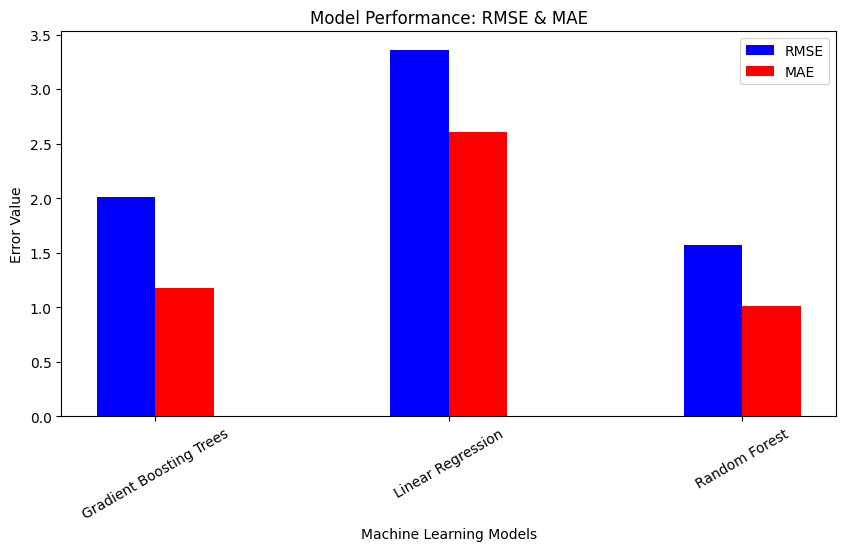

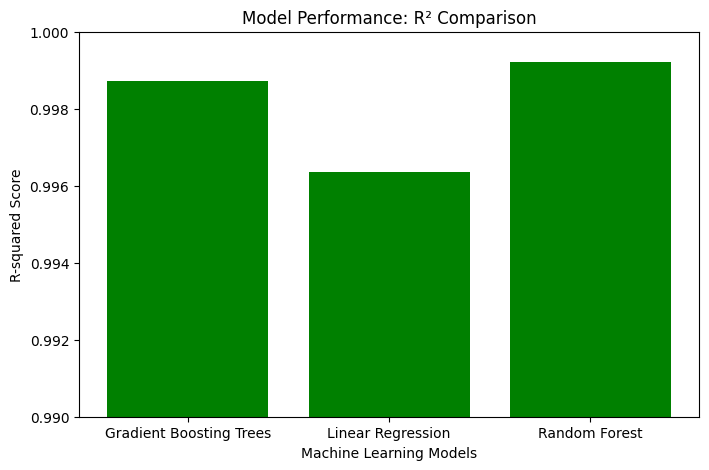

In [ ]:
evaluation_results = {
    "Model": ["Gradient Boosting Trees", "Linear Regression", "Random Forest"],
    "RMSE": [rmse_gbt, rmse_lr, rmse_rf],
    "MAE": [mae_gbt, mae_lr, mae_rf],
    "R²": [r2_gbt, r2_lr, r2_rf]
}

df = pd.DataFrame(evaluation_results)

bar_width = 0.2
x = np.arange(len(df["Model"]))

plt.figure(figsize=(10, 5))
plt.bar(x - bar_width/2, df["RMSE"], width=bar_width, label="RMSE", color='b')
plt.bar(x + bar_width/2, df["MAE"], width=bar_width, label="MAE", color='r')
plt.xlabel("Machine Learning Models")
plt.ylabel("Error Value")
plt.title("Model Performance: RMSE & MAE")
plt.xticks(ticks=x, labels=df["Model"], rotation=30)
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.bar(df["Model"], df["R²"], color='g')
plt.xlabel("Machine Learning Models")
plt.ylabel("R-squared Score")
plt.title("Model Performance: R² Comparison")
plt.ylim(0.99, 1.0)
plt.show()


## **Which Model is Best?**
🥇 Best Model: Random Forest Regressor

  Lowest RMSE (1.5654) & MAE (1.0028) → Best Accuracy<br>
  Highest R² (0.9992) → Explains nearly all variance in stock prices.<br>
  Handles non-linearity better than Linear Regression<br>

🥈 Runner-Up: Gradient Boosting Trees (GBT)

  Performs slightly worse than Random Forest but still outperforms Linear Regression.<br>
  Good balance of accuracy and efficiency.<br>

🥉 Least Performing: Linear Regression

  Struggles with non-linear relationships in stock price data.<br>
  Higher errors (RMSE: 3.3601, MAE: 2.6099) than both ensemble models.<br>


## **Conclusion**

This project implemented and compared three different machine learning models—**Linear Regression, Gradient Boosting Trees (GBT), and Random Forest Regressor**—for stock price prediction using **PySpark MLlib**. The dataset was preprocessed to include essential technical indicators such as **Moving Averages, Volatility, Momentum, and RSI**, ensuring that the models captured key trends and patterns in stock price movements.

### **Key Findings**
1. **Random Forest Regressor** emerged as the best-performing model with:
   - **Lowest RMSE (1.5654) & MAE (1.0028) → Best accuracy**.
   - **Highest R² (0.9992) → Best ability to explain variance in stock prices**.
   - **Superior handling of non-linearity** compared to Linear Regression.

2. **Gradient Boosting Trees (GBT)** performed well, but slightly below Random Forest, making it a strong alternative.
3. **Linear Regression had the lowest performance**, struggling to model complex stock price patterns, but it served as a useful baseline.

### **Future Improvements**
- **Enhancing Feature Engineering**: Incorporating additional features such as **trading volume, MACD, and sentiment analysis from financial news**.
- **Hyperparameter Optimization**: Fine-tuning parameters like **tree depth, learning rate, and number of trees** to improve accuracy further.
- **Real-Time Prediction Pipeline**: Deploying the best model into a **real-time stock prediction system using Kafka and Spark Streaming**.